In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

Tutorial link: https://www.tensorflow.org/tutorials/structured_data/feature_columns

In [3]:
dataframe = pd.read_csv("demographic.csv")

In [4]:
dataframe.dropna(inplace=True)

In [5]:
dataframe['target'] = dataframe['MB']

In [6]:
dataframe = dataframe.drop(['MB'], axis=1)

In [7]:
X = dataframe.drop(['target'], axis=1)
y = dataframe['target']

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)  

In [9]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [10]:
train_resampled = X_train_resampled.copy()
train_resampled['target'] = y_train_resampled

In [11]:
feature_columns = []

for header in ["BIO_SEX", "H1GI5A", "H1GI5B", "H1GI5C", "H1GI5D", "H1GI5E", "H1GI5F", "H1GI6A", "H1GI6B", "H1GI6C", "H1GI6D", "H1GI6E", "H1GI7A", "H1GI7B", "H1GI7C", "H1GI7D", "H1GI7E", "H1GI7F", "H1GI7G","H1SE1", "H1SE2", "H1SE3", "H1FS1", "H1FS2", "H1FS3", "H1FS4", "H1FS5", "H1FS7", "H1FS8", 
            "H1FS9", "H1FS11", "H1FS13", "H1FS14", "H1FS15", "H1FS17", "H1FS18", "H1FS19", "H1PF7", 
            "H1PF13", "H1PF14", "H1PF15", "H1PF16", "H1PF21", "H1PF30", "H1PF32", "H1PF33", "H1PF34", 
            "H1PF35", "H1PF36", "H1CO3", "H1CO6", "H1CO10", "H1NR3", "H1TO1", "H1TO3", "H1TO12", "H1TO13", 
            "H1TO20", "H1TO21", "H1TO23", "H1TO24", "H1TO27", "H1TO28", "H1DS1", "H1DS2", "H1DS3", "H1DS4",
            "H1DS5", "H1DS6", "H1DS7", "H1DS8", "H1DS9", "H1DS10", "H1DS11", "H1DS12", "H1DS13", "H1DS14",
            "H1DS15", "H1JO1", "H1JO3", "H1JO5", "H1JO7", "H1JO9", "H1JO10", "H1JO11", "H1JO12", "H1JO14",
            "H1JO17", "H1JO19", "H1JO20", "H1JO21", "H1JO23", "H1JO25", "H1JO26", "H1FV5", "H1FV7", 
            "H1FV8", "H1FV9", "H1SU1", "H1SU2"]:
    feature_columns.append(feature_column.numeric_column(header))


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [12]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
input_layer = tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],))  # This is for numeric inputs


In [13]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train_resampled, y_train_resampled)).shuffle(buffer_size=len(X_train_resampled)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [14]:
model = tf.keras.Sequential([
    input_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(1)
])

In [15]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=classes, 
    y=y_train
)

# Creating a dictionary of class weights
class_weight_dict = {classes[i]: class_weights[i] for i in range(len(classes))}
print(f"Class weights: {class_weight_dict}")

Class weights: {0.0: 1.4636655948553055, 1.0: 0.7594260927594261}


In [16]:
def specificity(y_true, y_pred):
    y_pred = tf.round(tf.nn.sigmoid(y_pred))  
    true_negatives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 0), 'float'))
    false_positives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 1), 'float'))
    
    specificity = true_negatives / (true_negatives + false_positives + tf.keras.backend.epsilon())
    return specificity

In [17]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(tf.nn.sigmoid(y_pred))  
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[
                  'accuracy',
                  tf.keras.metrics.AUC(name='auc'),
                  specificity,
                  tf.keras.metrics.Recall(name='sensitivity'),
                  f1_score
                      ]
             )

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [21]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
188/188 [==============================] - 1s 2ms/step - loss: 0.2706 - accuracy: 0.8418 - auc: 0.8798 - specificity: 0.9592 - sensitivity: 0.7014 - f1_score: 0.8344 - val_loss: 0.1226 - val_accuracy: 0.9338 - val_auc: 0.9617 - val_specificity: 0.9852 - val_sensitivity: 0.8973 - val_f1_score: 0.9596 - lr: 0.0010
Epoch 2/50
188/188 [==============================] - 0s 1ms/step - loss: 0.0892 - accuracy: 0.9550 - auc: 0.9657 - specificity: 0.9861 - sensitivity: 0.9162 - f1_score: 0.9580 - val_loss: 0.0711 - val_accuracy: 0.9554 - val_auc: 0.9819 - val_specificity: 0.9765 - val_sensitivity: 0.9389 - val_f1_score: 0.9769 - lr: 0.0010
Epoch 3/50
188/188 [==============================] - 0s 851us/step - loss: 0.0602 - accuracy: 0.9705 - auc: 0.9786 - specificity: 0.9905 - sensitivity: 0.9446 - f1_score: 0.9741 - val_loss: 0.0704 - val_accuracy: 0.9554 - val_auc: 0.9766 - val_specificity: 0.9859 - val_sensitivity: 0.9340 - val_f1_score: 0.9741 - lr: 0.0010
Epoch 4/50
188/188 [===

In [22]:
model.evaluate(
    test_ds,
)

41/41 [==============================] - 0s 549us/step - loss: 0.0487 - accuracy: 0.9792 - auc: 0.9864 - specificity: 0.9699 - sensitivity: 0.9780 - f1_score: 0.9837


[0.04873469099402428,
 0.9792467355728149,
 0.9863671660423279,
 0.9698822498321533,
 0.9780346751213074,
 0.9837175011634827]

In [23]:
import shap


In [24]:
background_data = shap.kmeans(X_train, 10)  # Use 10 clusters, adjust as necessary
explainer = shap.KernelExplainer(model.predict, background_data)
shap_values = explainer.shap_values(X_test)

1/1 [==============================] - 0s 58ms/step


  0%|          | 0/1301 [00:00<?, ?it/s]

695/695 [==============================] - 1s 718us/step


In [25]:
shap_values_reshaped = np.squeeze(shap_values)  # Removes the last dimension
print(shap_values_reshaped.shape)

(1301, 100)


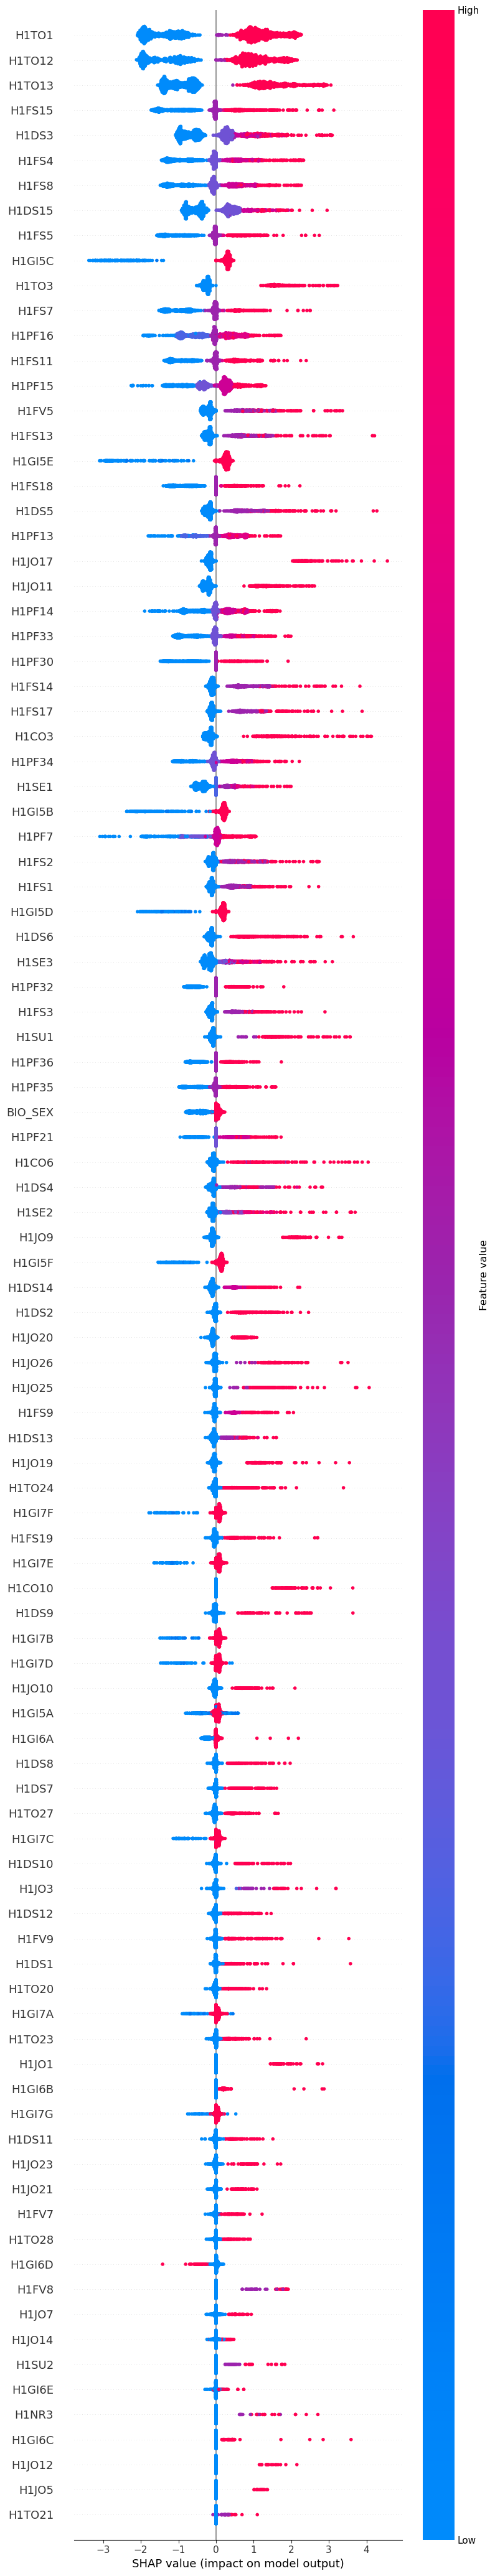

In [26]:
shap.summary_plot(shap_values_reshaped, X_test, max_display=X_test.shape[1])